In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os

awkward version  1.10.3
coffea version  0.7.21


In [2]:
from smp_utils import *
from cms_utils import *

In [3]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.analysis_tools import PackedSelection
from collections import defaultdict
from smp_utils import *
import tokenize as tok
import re
from cms_utils import *

In [4]:
class QJetMassProcessor(processor.ProcessorABC):
    '''
    Processor to run a Z+jets jet mass cross section analysis. 
    With "do_gen == True", will perform GEN selection and create response matrices. 
    Will always plot RECO level quantities. 
    '''
    def __init__(self, do_gen=True, ptcut=200., etacut = 2.5, ptcut_ee = 40., ptcut_mm = 29.,skimfilename=None):
        
        self.lumimasks = getLumiMaskRun2()
        
        # should have separate lower ptcut for gen
        self.do_gen=do_gen
        self.ptcut = ptcut
        self.etacut = etacut        
        self.lepptcuts = [ptcut_ee, ptcut_mm]
        
        if skimfilename != None: 
            if ".root" in skimfilename: 
                self.skimfilename = skimfilename.split(".root")[0]
            else: 
                self.skimfilename = skimfilename        
                
        binning = util_binning()
        
        ptreco_axis = binning.ptreco_axis
        mreco_axis = binning.mreco_axis
        ptgen_axis = binning.ptgen_axis     
        mgen_axis = binning.mgen_axis

        dataset_axis = binning.dataset_axis
        lep_axis = binning.lep_axis
        n_axis = binning.n_axis
        mass_axis = binning.mass_axis
        zmass_axis = binning.zmass_axis
        pt_axis = binning.pt_axis
        frac_axis = binning.frac_axis
        dr_axis = binning.dr_axis
        dr_fine_axis = binning.dr_fine_axis
        dphi_axis = binning.dphi_axis    
        
        ### Plots of things during the selection process / for debugging with fine binning
        h_njet_gen = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        h_njet_reco = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        h_ptjet_gen_pre = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptjet_reco_over_gen = hist.Hist(dataset_axis, frac_axis, storage="weight", label="Counts")
        h_drjet_reco_gen = hist.Hist(dataset_axis, dr_fine_axis, storage="weight", label="Counts")
        h_ptz_gen = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptz_reco = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")        
        h_mz_gen = hist.Hist(dataset_axis, zmass_axis, storage="weight", label="Counts")
        h_mz_reco = hist.Hist(dataset_axis, zmass_axis, storage="weight", label="Counts")
        h_mz_reco_over_gen = hist.Hist(dataset_axis, frac_axis, storage="weight", label="Counts")
        h_dr_z_jet_gen = hist.Hist(dataset_axis, dr_axis, storage="weight", label="Counts")
        h_dr_z_jet_reco = hist.Hist(dataset_axis, dr_axis, storage="weight", label="Counts")
        h_dphi_z_jet_gen = hist.Hist(dataset_axis, dphi_axis, storage="weight", label="Counts")
        h_dphi_z_jet_reco = hist.Hist(dataset_axis, dphi_axis, storage="weight", label="Counts")
        h_ptasym_z_jet_gen = hist.Hist(dataset_axis, frac_axis, storage="weight", label="Counts")
        h_ptasym_z_jet_reco = hist.Hist(dataset_axis, frac_axis, storage="weight", label="Counts")
        h_ptfrac_z_jet_gen = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")
        h_ptfrac_z_jet_reco = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")
        h_dr_gen_subjet = hist.Hist(dataset_axis, dr_axis, storage="weight", label="Counts")
        h_dr_reco_to_gen_subjet = hist.Hist(dataset_axis, dr_axis, storage="weight", label="Counts")
        
        #The new 3 plots
        h_pt_jet_reco_over_gen = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")
        h_pt_jet_over_z_gen = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")
        h_pt_z_gen_over_reco = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")
        
        ### Plots to be unfolded
        h_ptjet_mjet_u_reco = hist.Hist(dataset_axis, ptreco_axis, mreco_axis, storage="weight", label="Counts")
        h_ptjet_mjet_g_reco = hist.Hist(dataset_axis, ptreco_axis, mreco_axis, storage="weight", label="Counts")
        ### Plots for comparison
        h_ptjet_mjet_u_gen = hist.Hist(dataset_axis, ptgen_axis, mgen_axis, storage="weight", label="Counts")        
        h_ptjet_mjet_g_gen = hist.Hist(dataset_axis, ptgen_axis, mgen_axis, storage="weight", label="Counts")
        
        
        ### Plots to get JMR and JMS in MC
        h_m_u_jet_reco_over_gen = hist.Hist(dataset_axis, ptgen_axis, mgen_axis, frac_axis, storage="weight", label="Counts")
        h_m_g_jet_reco_over_gen = hist.Hist(dataset_axis, ptgen_axis, mgen_axis, frac_axis, storage="weight", label="Counts")
        
        ### Plots for the analysis in the proper binning
        h_response_matrix_u = hist.Hist(dataset_axis,
                                        ptreco_axis, mreco_axis, ptgen_axis, mgen_axis, 
                                        storage="weight", label="Counts")
        h_response_matrix_g = hist.Hist(dataset_axis,
                                        ptreco_axis, mreco_axis, ptgen_axis, mgen_axis, 
                                        storage="weight", label="Counts")
        
        cutflow = {}
        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "ptjet_gen_pre":h_ptjet_gen_pre, 
            "ptjet_mjet_u_gen":h_ptjet_mjet_u_gen, 
            "ptjet_mjet_u_reco":h_ptjet_mjet_u_reco, 
            "ptjet_mjet_g_gen":h_ptjet_mjet_g_gen, 
            "ptjet_mjet_g_reco":h_ptjet_mjet_g_reco, 
            "ptjet_reco_over_gen":h_ptjet_reco_over_gen,
            "drjet_reco_gen":h_drjet_reco_gen,
            "ptz_gen":h_ptz_gen,
            "ptz_reco":h_ptz_reco,
            "mz_gen":h_mz_gen,
            "mz_reco":h_mz_reco,            
            "mz_reco_over_gen":h_mz_reco_over_gen,
            "dr_z_jet_gen":h_dr_z_jet_gen,
            "dr_z_jet_reco":h_dr_z_jet_reco,            
            "dphi_z_jet_gen":h_dphi_z_jet_gen,
            "dphi_z_jet_reco":h_dphi_z_jet_reco,
            "ptasym_z_jet_gen":h_ptasym_z_jet_gen,
            "ptasym_z_jet_reco":h_ptasym_z_jet_reco,
            "ptfrac_z_jet_gen":h_ptfrac_z_jet_gen,
            "ptfrac_z_jet_reco":h_ptfrac_z_jet_reco,
            "m_u_jet_reco_over_gen":h_m_u_jet_reco_over_gen,
            "m_g_jet_reco_over_gen":h_m_g_jet_reco_over_gen,
            "dr_gen_subjet":h_dr_gen_subjet,
            "dr_reco_to_gen_subjet":h_dr_reco_to_gen_subjet,
            "response_matrix_u":h_response_matrix_u,
            "response_matrix_g":h_response_matrix_g,
            
            "pt_jet_reco_over_gen": h_pt_jet_reco_over_gen ,
            "pt_jet_over_z_gen" :  h_pt_jet_over_z_gen,
            "pt_z_gen_over_reco":  h_pt_z_gen_over_reco,
            "cutflow":cutflow
        }
        
        ## This is for rejecting events with large weights
        self.means_stddevs = defaultdict()
        

    @property
    def accumulator(self):
        #return self._histos
        return self.hists

    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        dataset = events.metadata['dataset']
        filename = events.metadata['filename']
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            
        #####################################
        #### Find the IOV from the dataset name
        #####################################
        IOV = ('2018' if any(re.findall(r'Test', dataset) )
               else '2016APV'   if any(re.findall(r'APV',  dataset)) 
               else '2018' if ( any(re.findall(r'UL18', dataset)) or any(re.findall(r'UL2018', dataset) ) )
               else '2017' if ( any(re.findall(r'UL17', dataset)) or any(re.findall(r'UL2017', dataset) ) )
               else '2016')
        
        #print("dataset ", dataset)
        #print("IOV ", IOV)

        #####################################
        #### Find the era from the file name
        #### Apply the good lumi mask
        #####################################
        if (self.do_gen):
            era = None
        else:
            firstidx = filename.find( "store/data/" )
            fname2 = filename[firstidx:]
            fname_toks = fname2.split("/")
            era = fname_toks[ fname_toks.index("data") + 1]
            print("IOV ", IOV, ", era ", era)
            lumi_mask = np.array(self.lumimasks[IOV](events.run, events.luminosityBlock), dtype=bool)
            events = events[lumi_mask]
        
        
        
        #####################################
        ### Initialize selection
        #####################################
        sel = PackedSelection()
        
        
         
        #####################################
        ### Trigger selection for data
        #####################################       
        if not self.do_gen:
            if "UL2016" in dataset: 
                trigsel = events.HLT.IsoMu24 | events.HLT.Ele27_WPTight_Gsf | events.HLT.Photon175
            elif "UL2017" in dataset:
                trigsel = events.HLT.IsoMu27 | events.HLT.Ele35_WPTight_Gsf | events.HLT.Photon200
            elif "UL2018" in dataset:
                trigsel = events.HLT.IsoMu24 | events.HLT.Ele32_WPTight_Gsf | events.HLT.Photon200
            elif "Test" in dataset: 
                trigsel = events.HLT.IsoMu24 | events.HLT.Ele32_WPTight_Gsf | events.HLT.Photon200
            else:
                raise Exception("Dataset is incorrect, should have 2016, 2017, 2018: ", dataset)
            sel.add("trigsel", trigsel)    
            
            #print("Here is trigsel")
            #print(sel.names)
            #print(sel.require(trigsel = True))
        
        #####################################
        ### Remove events with very large gen weights (>2 sigma)
        #####################################
        if self.do_gen:
            if dataset not in self.means_stddevs : 
                average = np.average( events["LHEWeight"].originalXWGTUP )
                stddev = np.std( events["LHEWeight"].originalXWGTUP )
                self.means_stddevs[dataset] = (average, stddev)            
            average,stddev = self.means_stddevs[dataset]
            vals = (events["LHEWeight"].originalXWGTUP - average ) / stddev
            self.hists["cutflow"][dataset]["all events"] += len(events)
            events = events[ np.abs(vals) < 2 ]
            self.hists["cutflow"][dataset]["weights cut"] += len(events)

            #####################################
            ### Initialize event weight to gen weight
            #####################################
            weights = events["LHEWeight"].originalXWGTUP
        else:
            weights = np.full( len( events ), 1.0 )
        
        


        
        #####################################
        #####################################
        #####################################
        ### Gen selection
        #####################################
        #####################################
        #####################################
        if self.do_gen:
            #####################################
            ### Events with at least one gen jet
            #####################################
            sel.add("oneGenJet", 
                  ak.sum( (events.GenJet.pt > 5.) & (np.abs(events.GenJet.eta) < 2.5), axis=1 ) >= 1
            )
            events.GenJet = events.GenJet[(events.GenJet.pt > 5.) & (np.abs(events.GenJet.eta) < 2.5)]

            #####################################
            ### Make gen-level Z
            #####################################
            z_gen = get_z_gen_selection(events, sel, self.lepptcuts[0], self.lepptcuts[1] )
            z_ptcut_gen = ak.where( sel.all("twoGen_leptons") & ~ak.is_none(z_gen),  z_gen.pt > 20., False )
            z_mcut_gen = ak.where( sel.all("twoGen_leptons") & ~ak.is_none(z_gen),  (z_gen.mass > 80.) & (z_gen.mass < 110), False )
            sel.add("z_ptcut_gen", z_ptcut_gen)
            sel.add("z_mcut_gen", z_mcut_gen)

            #####################################
            ### Get Gen Jet
            #####################################
            gen_jet, z_jet_dphi_gen = get_dphi( z_gen, events.GenJet )
            z_jet_dr_gen = gen_jet.delta_r(z_gen)



            #####################################
            ### Gen event topology selection
            #####################################        
            z_pt_asym_gen = np.abs(z_gen.pt - gen_jet.pt) / (z_gen.pt + gen_jet.pt)
            z_pt_frac_gen = gen_jet.pt / z_gen.pt
            z_pt_asym_sel_gen =  z_pt_asym_gen < 0.3
            z_jet_dphi_sel_gen = z_jet_dphi_gen > 2.8 #np.pi * 0.5
            sel.add("z_jet_dphi_sel_gen", z_jet_dphi_sel_gen)
            sel.add("z_pt_asym_sel_gen", z_pt_asym_sel_gen)

            '''
            print("z_gen pt ", z_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].pt)
            print("z_gen eta ", z_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].eta)
            print("z_gen phi ", z_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].phi)
            
            print("gen_jet pt ", gen_jet[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].pt)
            print("gen_jet eta ", gen_jet[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].eta)
            print("gen_jet phi ", gen_jet[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen].phi)            
            
            print(" dphi ", z_jet_dphi_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen])
            print(" asym ", z_pt_asym_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen])
            print(" dr   ", z_jet_dr_gen[z_ptcut_gen & z_mcut_gen & z_jet_dphi_sel_gen & z_pt_asym_sel_gen])
            '''
            
            #####################################
            ### Make gen plots with Z and jet cuts
            #####################################
            kinsel_gen = sel.require(twoGen_leptons=True,oneGenJet=True,z_ptcut_gen=True,z_mcut_gen=True)
            sel.add("kinsel_gen", kinsel_gen)
            #toposel_gen = sel.require(z_pt_asym_sel_gen=True,z_jet_dphi_sel_gen=True)
            toposel_gen = sel.require(z_jet_dphi_sel_gen=True)
            sel.add("toposel_gen", toposel_gen)
            self.hists["ptz_gen"].fill(dataset=dataset,
                                      pt=z_gen[kinsel_gen].pt,
                                      weight=weights[kinsel_gen])
            self.hists["mz_gen"].fill(dataset=dataset,
                                      mass=z_gen[kinsel_gen].mass,
                                      weight=weights[kinsel_gen])
            self.hists["njet_gen"].fill(dataset=dataset,
                                        n=ak.num(events[kinsel_gen].GenJet),
                                        weight = weights[kinsel_gen] )

            # There are None elements in these arrays when the reco_jet is not found.
            # To make "N-1" plots, we need to reduce the size and remove the Nones
            # otherwise the functions will throw exception.
            weights2 = weights[ ~ak.is_none(gen_jet) & kinsel_gen]
            z_jet_dr_gen2 = z_jet_dr_gen[ ~ak.is_none(gen_jet) & kinsel_gen]
            z_pt_asym_sel_gen2 = z_pt_asym_sel_gen[~ak.is_none(gen_jet) & kinsel_gen]
            z_pt_asym_gen2 = z_pt_asym_gen[~ak.is_none(gen_jet) & kinsel_gen]
            z_jet_dphi_gen2 = z_jet_dphi_gen[~ak.is_none(gen_jet) & kinsel_gen]
            z_pt_frac_gen2 = z_pt_frac_gen[~ak.is_none(gen_jet) & kinsel_gen]
            z_jet_dphi_sel_gen2 = z_jet_dphi_sel_gen[~ak.is_none(gen_jet) & kinsel_gen]

            # Making N-1 plots for these three
            self.hists["dr_z_jet_gen"].fill( dataset=dataset,
                                              dr=z_jet_dr_gen2[z_pt_asym_sel_gen2],
                                              weight=weights2[z_pt_asym_sel_gen2])
            self.hists["dphi_z_jet_gen"].fill(dataset=dataset, 
                                               dphi=z_jet_dphi_gen2[z_pt_asym_sel_gen2], 
                                               weight=weights2[z_pt_asym_sel_gen2])
            self.hists["ptasym_z_jet_gen"].fill(dataset=dataset, 
                                                 frac=z_pt_asym_gen2[z_jet_dphi_sel_gen2],
                                                 weight=weights2[z_jet_dphi_sel_gen2])
            #self.hists["ptfrac_z_jet_gen"].fill(dataset=dataset, 
                                                 # ptreco=z_gen[z_jet_dphi_sel_gen2].pt,
                                                 # frac=z_pt_frac_gen2[z_jet_dphi_sel_gen2],
                                                 # weight=weights2[z_jet_dphi_sel_gen2])

            #####################################
            ### Get gen subjets 
            #####################################
            gensubjets = events.SubGenJetAK8
            groomed_gen_jet, groomedgensel = get_groomed_jet(gen_jet, gensubjets, False)

            #####################################
            ### Convenience selection that has all gen cuts
            #####################################
            allsel_gen = sel.all("kinsel_gen", "toposel_gen" )
            sel.add("allsel_gen", allsel_gen)

            #####################################
            ### Plots for gen jets and subjets
            #####################################
            self.hists["ptjet_gen_pre"].fill(dataset=dataset, 
                                         pt=gen_jet[allsel_gen].pt, 
                                         weight=weights[allsel_gen])
            self.hists["dr_gen_subjet"].fill(dataset=dataset,
                                             dr=groomed_gen_jet[allsel_gen].delta_r(gen_jet[allsel_gen]),
                                             weight=weights[allsel_gen])
            
            
        #####################################
        ### Make reco-level Z
        #####################################
        z_reco = get_z_reco_selection(events, sel, self.lepptcuts[0], self.lepptcuts[1])
        

        
        z_ptcut_reco = z_reco.pt > 20.
        z_mcut_reco = (z_reco.mass > 80.) & (z_reco.mass < 110.)
        sel.add("z_ptcut_reco", z_ptcut_reco)
        sel.add("z_mcut_reco", z_mcut_reco)
        
        #####################################
        ### Reco jet selection
        #####################################
        recojets = events.Jet[(events.Jet.pt > 20.) & (np.abs(events.Jet.eta) < 2.5)]
        sel.add("oneRecoJet", 
             ak.sum( (events.Jet.pt > 20.) & (np.abs(events.Jet.eta) < 2.5), axis=1 ) >= 1
        )
        
        #####################################
        # Find reco jet opposite the reco Z
        #####################################
        reco_jet, z_jet_dphi_reco = get_dphi( z_reco, events.Jet )
        z_jet_dr_reco = reco_jet.delta_r(z_reco)
        z_jet_dphi_reco_values = z_jet_dphi_reco
        
        #####################################
        ### Reco event topology sel
        #####################################
        z_jet_dphi_sel_reco = z_jet_dphi_reco > 2.8 #np.pi * 0.5
        z_pt_asym_reco = np.abs(z_reco.pt - reco_jet.pt) / (z_reco.pt + reco_jet.pt)
        z_pt_frac_reco = reco_jet.pt / z_reco.pt
        z_pt_asym_sel_reco = z_pt_asym_reco < 0.3
        sel.add("z_jet_dphi_sel_reco", z_jet_dphi_sel_reco)
        sel.add("z_pt_asym_sel_reco", z_pt_asym_sel_reco)

        kinsel_reco = sel.require(twoReco_leptons=True,oneRecoJet=True,z_ptcut_reco=True,z_mcut_reco=True)
        sel.add("kinsel_reco", kinsel_reco)
        #toposel_reco = sel.require(z_pt_asym_sel_reco=True,z_jet_dphi_sel_reco=True)
        toposel_reco = sel.require(z_jet_dphi_sel_reco=True)
        sel.add("toposel_reco", toposel_reco)

        
        # Note: Trigger is not applied in the MC, so this is 
        # applying the full gen selection here to be in sync with rivet routine
        if self.do_gen:
            presel_reco = sel.all("allsel_gen", "kinsel_reco")
        else:
            presel_reco = sel.all("trigsel", "kinsel_reco")
        allsel_reco = presel_reco & toposel_reco
        sel.add("presel_reco", presel_reco)
        sel.add("allsel_reco", allsel_reco)

        self.hists["mz_reco"].fill(dataset=dataset, mass=z_reco[presel_reco].mass, 
                                   weight=weights[presel_reco])
        if self.do_gen:
            self.hists["mz_reco_over_gen"].fill(dataset=dataset, 
                                                frac=z_reco[presel_reco].mass / z_gen[presel_reco].mass, 
                                                weight=weights[presel_reco] )

        # There are None elements in these arrays when the reco_jet is not found.
        # To make "N-1" plots, we need to reduce the size and remove the Nones
        # otherwise the functions will throw exception.
        weights3 = weights[ ~ak.is_none(reco_jet)]
        presel_reco3 = presel_reco[~ak.is_none(reco_jet)]
        z_jet_dr_reco3 = z_jet_dr_reco[ ~ak.is_none(reco_jet)]
        z_pt_asym_sel_reco3 = z_pt_asym_sel_reco[~ak.is_none(reco_jet)]
        z_pt_asym_reco3 = z_pt_asym_reco[~ak.is_none(reco_jet)]
        z_pt_frac_reco3 = z_pt_frac_reco[~ak.is_none(reco_jet)]
        z_jet_dphi_reco3 = z_jet_dphi_reco[~ak.is_none(reco_jet)]
        z_jet_dphi_sel_reco3 = z_jet_dphi_sel_reco[~ak.is_none(reco_jet)]
        
        # Making N-1 plots for these three
        self.hists["dr_z_jet_reco"].fill( dataset=dataset,
                                          dr=z_jet_dr_reco3[presel_reco3 & z_pt_asym_sel_reco3],
                                          weight=weights3[presel_reco3 & z_pt_asym_sel_reco3])
        self.hists["dphi_z_jet_reco"].fill(dataset=dataset, 
                                           dphi=z_jet_dphi_reco3[presel_reco3 & z_pt_asym_sel_reco3], 
                                           weight=weights3[presel_reco3 & z_pt_asym_sel_reco3])
        self.hists["ptasym_z_jet_reco"].fill(dataset=dataset, 
                                             frac=z_pt_asym_reco3[presel_reco3 & z_jet_dphi_sel_reco3],
                                             weight=weights3[presel_reco3 & z_jet_dphi_sel_reco3])
        #self.hists["ptfrac_z_jet_reco"].fill(dataset=dataset, 
#                                              ptreco=z_reco[presel_reco3 & z_jet_dphi_sel_reco3].pt,
#                                              frac=z_pt_frac_reco3[presel_reco3 & z_jet_dphi_sel_reco3],
#                                              weight=weights3[presel_reco3 & z_jet_dphi_sel_reco3])
        
        #####################################
        ### Make final selection plots here
        #####################################
        
        # For convenience, finally reduce the size of the arrays at the end
        weights = weights[allsel_reco]
        z_reco = z_reco[allsel_reco]
        reco_jet = reco_jet[allsel_reco]
        self.hists["ptjet_mjet_u_reco"].fill( dataset=dataset, ptreco=reco_jet.pt, mreco=reco_jet.mass, weight=weights )
        #self.hists["ptjet_mjet_g_reco"].fill( dataset=dataset, ptreco=reco_jet.pt, mreco=reco_jet.msoftdrop, weight=weights )
        
#         ############################################################################################################
#         #### Add another selection that the distace between reco_jet and gen_jet is < R/2 (0.2 for AK4 jets) #######
#         ############################################################################################################ Aritra
#         delta_phi = reco_jet.phi - gen_jet.phi

#         delta_phi = np.where(delta_phi <= np.pi,    delta_phi, delta_phi + 2*np.pi)
#         delta_phi = np.where(delta_phi > - np.pi,  delta_phi, delta_phi + 2*np.pi)

#         delta_eta = reco_jet.eta - gen_jet.eta

#         # delta_eta = np.where(delta_eta <= np.pi,    delta_eta, delta_eta + 2*np.pi)
#         # delta_eta = np.where(delta_eta > - np.pi,  delta_eta, delta_eta + 2*np.pi)

#         delta_R = np.sqrt(delta_phi**2 + delta_eta**2)
#         allignment = (delta_R < 0.2 )  # Since, R = 0.4 and we require it to be less than 0.2
        
        
        
        if self.do_gen:
            z_gen = z_gen[allsel_reco]
            gen_jet = gen_jet[allsel_reco]
            groomed_gen_jet = groomed_gen_jet[allsel_reco]


            self.hists["ptjet_mjet_u_gen"].fill( dataset=dataset, ptgen=gen_jet.pt, mgen=gen_jet.mass, weight=weights )
            self.hists["ptjet_mjet_g_gen"].fill( dataset=dataset, ptgen=gen_jet.pt, mgen=groomed_gen_jet.mass, weight=weights )
            
            self.hists["drjet_reco_gen"].fill(dataset=dataset, dr=reco_jet.delta_r(gen_jet), weight=weights)
            
        
            self.hists["ptjet_reco_over_gen"].fill(dataset=dataset, frac=reco_jet.pt/gen_jet.pt, weight=weights)
            self.hists["m_u_jet_reco_over_gen"].fill(dataset=dataset, 
                                                     ptgen=gen_jet.pt, mgen = gen_jet.mass, 
                                                     frac=reco_jet.mass/gen_jet.mass, weight=weights)
            #self.hists["m_g_jet_reco_over_gen"].fill(dataset=dataset, 
                                                     #ptgen=gen_jet.pt, mgen=groomed_gen_jet.mass,
                                                     #frac=reco_jet.msoftdrop/groomed_gen_jet.mass, weight=weights)
                    
                    
            
#             delta_R < phi/2
#             delta_phi = reco_jet.phi - gen_jet.phi

#             delta_phi = np.where(delta_phi <= np.pi,    delta_phi, delta_phi + 2*np.pi)
#             delta_phi = np.where(delta_phi > - np.pi,  delta_phi, delta_phi + 2*np.pi)

#             delta_eta = reco_jet.eta - gen_jet.eta
            
#             # delta_eta = np.where(delta_eta <= np.pi,    delta_eta, delta_eta + 2*np.pi)
#             # delta_eta = np.where(delta_eta > - np.pi,  delta_eta, delta_eta + 2*np.pi)

#             delta_R = np.sqrt(delta_phi**2 + delta_eta**2)
            
#             aligned = True
#             for dR in delta_R:
#                 if (dR > 0.2):
#                     aligned = False
 

            
            # not_aligned = np.where(delta_R > 0.2)[0]
            # rjpt = np.delete(reco_jet.pt,not_aligned )
            # gjpt = np.delete(gen_jet.pt, not_aligned)
            # zrpt = np.delete(z_reco.pt, not_aligned)
            # zgpt = np.delete(z_gen.pt, not_aligned)
            # print(len(rjpt))
            # print(len(gjpt))
            # print(len(zrpt))
            # print(len(zgpt))
            
            self.hists["pt_jet_over_z_gen"].fill( dataset = dataset, ptreco = z_reco.pt, frac = gen_jet.pt / z_gen.pt , weight = weights)
            self.hists["pt_z_gen_over_reco"].fill(dataset = dataset, ptreco = z_reco.pt, frac = z_gen.pt/z_reco.pt, weight = weights )
            self.hists["pt_jet_reco_over_gen"].fill(dataset = dataset, ptreco = z_reco.pt, frac = reco_jet.pt/gen_jet.pt, weight = weights )
                # self.hists["pt_jet_over_z_gen"].fill( dataset = dataset, ptreco = zrpt, frac = gjpt / zgpt , weight = weights)
                # self.hists["pt_z_gen_over_reco"].fill(dataset = dataset, ptreco = zrpt, frac = zgpt/zrpt, weight = weights )
                # self.hists["pt_jet_reco_over_gen"].fill(dataset = dataset, ptreco = zrpt, frac = rjpt/gjpt, weight = weights )
            self.hists["ptfrac_z_jet_reco"].fill(dataset=dataset, ptreco=z_reco.pt, frac=z_reco.pt/reco_jet.pt, weight=weights)
            
            self.hists["ptfrac_z_jet_gen"].fill(dataset=dataset, ptreco=z_gen.pt,frac=z_gen.pt/gen_jet.pt, weight=weights)
            
            #h_pt_z_gen_over_reco = hist.Hist(dataset_axis, ptreco_axis, frac_axis, storage="weight", label="Counts")


            #self.hists["response_matrix_u"].fill( dataset=dataset, 
             #                                  ptreco=reco_jet.pt, ptgen=gen_jet.pt,
               #                                mreco=reco_jet.mass, mgen=gen_jet.mass )
            #self.hists["response_matrix_g"].fill( dataset=dataset, 
                                               #ptreco=reco_jet.pt, ptgen=gen_jet.pt,
                                               #mreco=reco_jet.msoftdrop, mgen=groomed_gen_jet.mass )
            

            #weird = (reco_jet.msoftdrop/groomed_gen_jet.mass > 2.0) & (reco_jet.msoftdrop > 10.)#not commented by Aritra
            #weird = (np.abs(reco_jet.msoftdrop - groomed_gen_jet.mass) > 20.0) & (reco_jet.msoftdrop > 10.)
            
            
            #recosubjets = events.SubJet[allsel_gen & allsel_reco]           
            #subjet1 = reco_jet.subjets[:,0]
            #subjet2 = reco_jet.subjets[:,1]
            #gensubjet1,drsub1 = find_closest_dr(subjet1, gensubjets[allsel_gen & allsel_reco])
            #gensubjet2,drsub2 = find_closest_dr(subjet2, gensubjets[allsel_gen & allsel_reco])
            
            #self.hists["dr_reco_to_gen_subjet"].fill(dataset=dataset, 
                                                     #dr=drsub1[~ak.is_none(drsub1) & ~ak.is_none(drsub2)], 
                                                     #weight=weights[~ak.is_none(drsub1) & ~ak.is_none(drsub2)])
           # self.hists["dr_reco_to_gen_subjet"].fill(dataset=dataset, 
                                                     #dr=drsub2[~ak.is_none(drsub1) & ~ak.is_none(drsub2)], 
                                                     #weight=weights[~ak.is_none(drsub1) & ~ak.is_none(drsub2)])
            
            '''
            print("gen  pt ", gen_jet[weird].pt)
            print("gen  eta ", gen_jet[weird].eta)
            print("gen  phi ", gen_jet[weird].phi)
            print("gen  m ", gen_jet[weird].mass)
            print("ggen pt ", groomed_gen_jet[weird].pt)
            print("ggen eta ", groomed_gen_jet[weird].eta)
            print("ggen phi ", groomed_gen_jet[weird].phi)
            print("ggen m ", groomed_gen_jet[weird].mass)

            
            print("reco pt ", reco_jet[weird].pt)
            print("reco eta ", reco_jet[weird].eta)
            print("reco phi ", reco_jet[weird].phi)
            print("reco m ", reco_jet[weird].mass)
            print("reco m ", reco_jet[weird].msoftdrop)
            print("subjetIdx1 ", reco_jet[weird].subJetIdx1)
            print("subjetIdx2 ", reco_jet[weird].subJetIdx2)
            
            print("gensubjets pt  ", gensubjets[allsel_gen & allsel_reco][weird].pt)
            print("gensubjets eta ", gensubjets[allsel_gen & allsel_reco][weird].eta)
            print("gensubjets phi ", gensubjets[allsel_gen & allsel_reco][weird].phi)
            print("gensubjets m   ", gensubjets[allsel_gen & allsel_reco][weird].mass)
        
            print("recosubjets pt  ", recosubjets[weird].pt)
            print("recosubjets eta ", recosubjets[weird].eta)
            print("recosubjets phi ", recosubjets[weird].phi)
            print("recosubjets m   ", recosubjets[weird].mass)

            
            print("gensubjet1 pt  ", gensubjet1[weird].pt)
            print("gensubjet1 eta ", gensubjet1[weird].eta)
            print("gensubjet1 phi ", gensubjet1[weird].phi)
            print("gensubjet1 m   ", gensubjet1[weird].mass)

            print("gensubjet2 pt  ", gensubjet2[weird].pt)
            print("gensubjet2 eta ", gensubjet2[weird].eta)
            print("gensubjet2 phi ", gensubjet2[weird].phi)
            print("gensubjet2 m   ", gensubjet2[weird].mass)
            
            print("subjet1 pt  ", subjet1[weird].pt)
            print("subjet1 eta ", subjet1[weird].eta)
            print("subjet1 phi ", subjet1[weird].phi)
            print("subjet1 m   ", subjet1[weird].mass)

            print("subjet2 pt  ", subjet2[weird].pt)
            print("subjet2 eta ", subjet2[weird].eta)
            print("subjet2 phi ", subjet2[weird].phi)
            print("subjet2 m   ", subjet2[weird].mass)
            
            print("DR subjet 1 ", drsub1[weird])
            print("DR subjet 2 ", drsub2[weird])
            '''
        
        for name in sel.names:
            self.hists["cutflow"][dataset][name] = sel.all(name).sum()
        
        return self.hists

    
    def postprocess(self, accumulator):
        return accumulator
    
    
    
    


In [5]:
# Can grab a file on cmslpc from 
# /store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50TuneCUETP8M113TeV-madgraphMLM-pythia8RunIISummer16MiniAODv3-PUMoriond17_ext2-v2/190513_171710/0000/*.root
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import glob
import pickle

In [6]:


def response_maker_nanov9(testing=False, do_gen=True, client=None, prependstr = "root://xcache/",skimfilename=None): 

    filedir = "samples/"

    eras_data = [
        'UL16NanoAOD', 
        'UL16NanoAODAPV', 
        'UL17NanoAOD', 
        'UL18NanoAOD'
           ]
    eras_mc = [
        'UL16NanoAODv9', 
        'UL17NanoAODv9',
        'UL18NanoAODv9'
    ]
    
    bins = [
    "100to200",
    "1200to2500",
    "200to400",
    "2500toInf",
    "400to600",
    "600to800",
    "70to100",
    "800to1200"
    ]

    
    
    if not testing: 
        nworkers = 8
        chunksize = 1000000
        maxchunks = None
    else:
        nworkers = 1
        if do_gen: 
            chunksize = 1000
        else:
            chunksize=100000
        maxchunks = 15
    fileset = {}
    folderset = {}
    folderstr = "DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_%s_folders.txt"
    for era in eras_mc:
        folderset[era] = {}
        filename = filedir+folderstr%(era)
        for i,binn in enumerate(bins):
            with open(filename) as f:
                    folder = f.readlines()[i].rstrip()
            folderset[era][binn] = prependstr+folder+'skimmed/'
        
        
    if not testing: 
        
        if do_gen:

            #dy_mc_filestr = "DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_%s_files.txt"
            folderstr = "DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_%s_folders.txt"
            for era in eras_mc: 
                filename =  filedir+folderstr%(era)
                for i,binn in enumerate(bins):
                    with open(filename) as f:
                        skimmed_mc_files = [prependstr + i.rstrip() + 'skimmed/skimmed_total.root' for i in f.readlines() if i[0] != "#" ]
                        fileset[era] = skimmed_mc_files
        else: 
            datasets_data = [
                'SingleElectron_UL2016APV',
                'SingleElectron_UL2016',
                'SingleElectron_UL2017',
                'EGamma_UL2018',
                'SingleMuon_UL2016APV',
                'SingleMuon_UL2016',
                'SingleMuon_UL2017',
                'SingleMuon_UL2018',
            ]

            for dataset in datasets_data: 
                filename = filedir + dataset + '_NanoAODv9_files.txt'
                with open(filename) as f:
                    data_files = [prependstr + i.rstrip() for i in f.readlines()  if i[0] != "#" ]
                    fileset[dataset] = data_files
    else: 
        if do_gen:
            fileset["Test"] = [prependstr + "/store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/26793660-5D04-C24B-813E-3C1744C84D2D.root"]
        else: 
            fileset["Test"] = [prependstr + "/store/data/Run2018A/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9_GT36-v1/2820000/FF8A3CD2-3F51-7A43-B56C-7F7B7B3158E3.root"]

                    
                
    if client == None or testing == True:         
        run = processor.Runner(
            executor = processor.FuturesExecutor(compression=None, workers=nworkers),
            schema=NanoAODSchema,
            chunksize=chunksize,
            maxchunks=maxchunks,
            skipbadfiles=True
        )
    else: 
        run = processor.Runner(
            executor = processor.DaskExecutor(client=client),
            schema=NanoAODSchema,
            chunksize=chunksize,
            maxchunks=maxchunks,
            skipbadfiles=True
        )
        
    output = run(
        fileset,
        "Events",
        processor_instance=QJetMassProcessor(do_gen=do_gen, skimfilename=skimfilename),
    )

        
    
    if do_gen:
        fname_out = 'qjetmass_zjets_gen.pkl'
    else:
        fname_out = 'qjetmass_zjets_reco.pkl'
    with open(fname_out, "wb") as f:
        pickle.dump( output, f )


In [7]:
# fileset = {}
# filedir = "samples/"
# prependstr = "/mnt/data/cms"

# years = ["2016/","2017/","2018/"]

# eras_mc = [
#         'UL16NanoAODv9', 
#         'UL17NanoAODv9', 
#         'UL18NanoAODv9'
#     ]

# bins = [
#     "100to200",
#     "1200to2500",
#     "200to400",
#     "2500toInf",
#     "400to600",
#     "600to800",
#     "70to100",
#     "800to1200"
# ]


# folderstr = "DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_%s_folders.txt"
# for era in eras_mc: 
#     filename =  filedir+folderstr%(era)
#     for i,binn in enumerate(bins):
#         with open(filename) as f:
#             dy_mc_files = [prependstr + i.rstrip() + 'skimmed/skimmed_total.root' for i in f.readlines() if i[0] != "#" ]
#             fileset[era] = dy_mc_files

In [8]:
# fileset

In [9]:
# f = uproot.open(fileset['UL18NanoAODv9'][-2])
# f["Events"].keys()

In [10]:
# a = f["Events"]["Jet_pt"].array(library = "np")

In [11]:
# a[2]

In [12]:
response_maker_nanov9(testing= False, do_gen=True, client=None, prependstr="/mnt/data/cms")


Output()

Output()

In [13]:
with open("qjetmass_zjets_gen.pkl", "rb") as f:
    output = pickle.load( f )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7effc7d36310>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

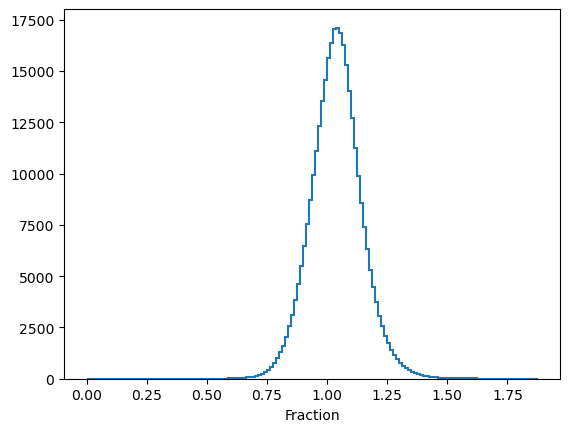

In [14]:
output['ptjet_reco_over_gen'].project('frac').plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7effc7bada60>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

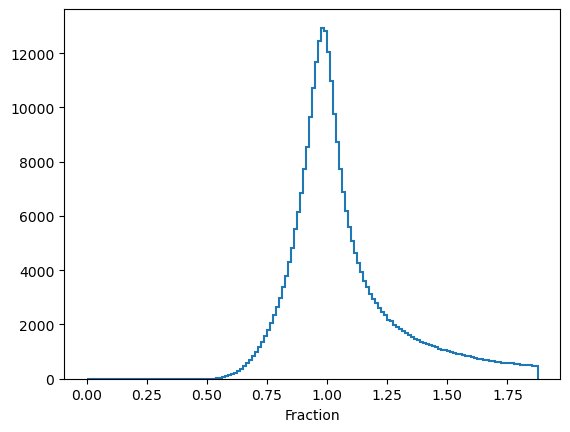

In [15]:
output['pt_jet_over_z_gen'].project('frac').plot()